In [4]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import sys
import re
import glob

In [9]:
# Find out all csv files included in the folder ../2023_05_24_smina_screen
csv_files = glob.glob('../data/2023_05_24_smina_screen/*.csv')
# Read all csv files and add a column to indicate the name of the csv file
df_smina = pd.concat([pd.read_csv(f).assign(filename=os.path.basename(f)) for f in csv_files])

# Set an exhaustiveness columns with value of 16
df_smina['exhaustiveness'] = 16

# For each Ligand and receptor combination, compute the standard deviation of the scores
df_smina_std = df_smina.groupby(['Ligand', 'receptor'])['Score'].std().reset_index()


In [22]:
# For each Ligand find the lowest score and the corresponding output file, only taking pose 1 into account
df_smina_min = df_smina[df_smina['Pose'] == 1].groupby(['Ligand'])['Score'].min().reset_index()
df_smina_min = df_smina_min.merge(df_smina, on=['Ligand', 'Score'], how='left')

# Include only Pose 1 in the dataframe
df_smina_min = df_smina_min[df_smina_min['Pose'] == 1]

# Rename ligand column to cluster
df_smina_min = df_smina_min.rename(columns={'ligand': 'Cluster'})

# Leave only cluster number in the cluster column. It is found in at the end of the string after the underscore
df_smina_min['Cluster'] = df_smina_min['Cluster'].str.split('_').str[-1]

# Sort the dataframe by Score in ascending order
df_smina_min = df_smina_min.sort_values(by=['Score'])

# Keep only minimum scores for each ligand.
df_smina_min = df_smina_min.drop_duplicates(subset=['Ligand'])

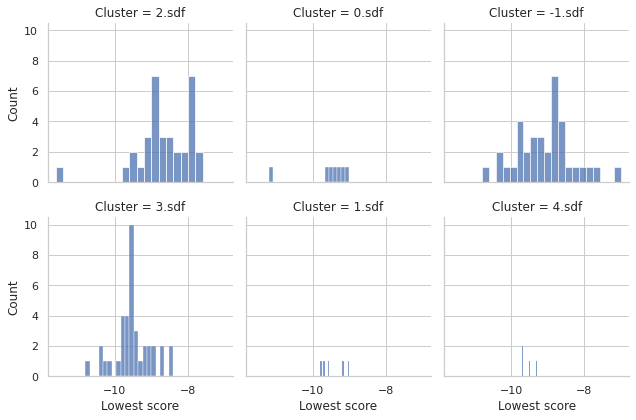

In [25]:
# Plot distribution of the lowest score per cluster in subplots with shared x-axis
g = sns.FacetGrid(df_smina_min, col="Cluster", col_wrap=3, sharex=True)
g.map_dataframe(sns.histplot, x="Score", bins=20)
g.set_axis_labels("Lowest score", "Count")
plt.show()


In [6]:
# Which pockets are found in df_smina_min?
df_smina_min['receptor'].unique()


array(['../2023_04_13_dogsitescorer/cluster_pockets/frame_118.pdb',
       '../2023_04_13_dogsitescorer/cluster_pockets/frame_6891.pdb'],
      dtype=object)

In [7]:
# How many ligands are found in each pocket?
df_smina_min.groupby(['receptor'])['Ligand'].count().reset_index().head()

,receptor,Ligand
0,../2023_04_13_dogsitescorer/cluster_pockets/fr...,105
1,../2023_04_13_dogsitescorer/cluster_pockets/fr...,20


In [8]:
# Which clusters are found in each pocket?
df_smina_min.groupby(['receptor'])['Cluster'].unique().reset_index().head()


,receptor,Cluster
0,../2023_04_13_dogsitescorer/cluster_pockets/fr...,"[-1.sdf, 1.sdf, 0.sdf, 2.sdf, 3.sdf, 4.sdf]"
1,../2023_04_13_dogsitescorer/cluster_pockets/fr...,"[-1.sdf, 0.sdf, 2.sdf, 4.sdf]"


In [9]:
# Count the number of ligands per cluster
df_smina_min.groupby(['Cluster'])['Ligand'].count().reset_index().head()

,Cluster,Ligand
0,-1.sdf,36
1,0.sdf,7
2,1.sdf,5
3,2.sdf,34
4,3.sdf,38


In [5]:
# Find out the relevant pdb file in the folder ../2023_05_24_smina_screen for each ligand in df_smina_min
df_smina_min['pdb_file'] = df_smina_min['filename'].str.split('.csv').str[0]
df_smina_min['pdb_file'] = df_smina_min['pdb_file'] + '_' + df_smina_min['Ligand'] + '_1.pdb' 

In [6]:
# Copy the pdb_files that are found in any of the subfolders of the folder ../2023_05_24_smina_screen to a subfolder here called pdb_files

# Create the folder pdb_files if it does not exist
if not os.path.exists('pdb_files'):
    os.makedirs('pdb_files')
    
for pdb_file in df_smina_min['pdb_file']:
    os.system('cp ../2023_05_24_smina_screen/*/' + pdb_file + ' pdb_files/')


In [ ]:
# Write df_smina_min to a csv file
df_smina_min.to_csv('../data/df_smina_min.csv', index=False)